# Building a Data Pipeline for Analysing Global Land Temperatures
### Data Engineering Capstone Project

#### Project Summary
 This purpose of the project is to build a data pipeline and warehouse that will serve as the source of data for analysing the relationship of population density and green house emission on global land temeperatures.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [3]:
# Do all imports and installs here
import pandas as pd
import json
import os
import configparser
import boto3
import shutil
from botocore.exceptions import ClientError
from pyspark.sql.functions import year, month, dayofmonth, col,to_date, avg
from IPython.display import Image

## Step 1: Scope the Project and Gather Data

### 1.1 Scope
Over the years, the emissions of green house gases like C02, Methane, e.t.c has greatly affected the ozone layer, depleting it, resulting in the green house effect, an increase in climatic temperatures or global warning. Studies has also shown that an increase in population density has an effect on the surface temperatures.

The aim of the project is to create a data warehouse containing structured data can be used by a data science team to investigate the effect of greeen house gases emissions and population density on climatic temperatures in countries over years. 

By the end of this project a data model would have been created using the snowflake schema, quality checks added and structured data that can easily be used saved in Amazon Redshift as a data warehouse.

This warehouse is meant to be uses by data scientists in the analytics team of the company to provide further insight . The data in the data warehouse will be structured so that the analytics team can succesfully get data to help solve amongst others, some of the following:
- The relationship betweeen population density, green house emissions and average land temperature.
- Time series forecasting of the expected average land temperature, population density and green house emissions for countries on a yearly basis
- Also investigating if a time of the year (month) has an effect on the increase in global land temperatures

Some of the tools used in this project include SQLDBM for visualization of database model, Pandas for initial data exploration, Apache Spark for ETL , Redshift for data warehousing, Airflow for data pipelining.


### 1.2 Data Acquisition

The data for this project was gotten from four sources. This varied sources is then aggregated at the ETL stage.

#### Global land temperatures by cities and countries

Data on Global land temperatures by cities and countries was gotten from an open dataset on [Kaggle](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data). 

The GlobalLandTemperaturesByCity contains seven (7) columns and about eight 8.6 million rows.  The  columns include date in months for each year per city from the year 1743 through to 2013. Other columns are the Average temperature, Average Temperature Uncertianty,City, Country, Latitude, Longitude.

The GlobalLandTemperaturesByCountry contains four (4) columns and about 570 thousand rows . The columns include date, Average Temperature, Average Temperature Uncertainty and Country.

#### Green House Emissions

The data og green house emission is gotten from an open dataset on [OurWorldInData](https://ourworldindata.org/greenhouse-gas-emissions). It contains data on data emissions from 1990 to 2016  of 193 countries . It contains about 5200 rows and 4 columns including Entity (country), Code (three letter country iso code), Year and Total GHG emissions including LUCF (CAIT)

#### Population Density 
The data on population density for countries from the open dataset in [OurWorldInData](https://ourworldindata.org/world-population-growth).

The world population density data contains the average population density of about 262 countries from 1961 to 2017. It contains 14600 rows and 4 columns including Entity(country), Code (thre letter country iso code), Year and Population Density in Per square kilometer of land.

#### Country and Continents
The data on country and continent was collected to map continent to country knowing that the data scientist would like to investigate which continent tend to be more affected by climatic issues. The data is gotten from [datahub](https://datahub.io/JohnSnowLabs/country-and-continent-codes-list). It has information on 254 countries and there respective continent. It contains 261 rows and six columns including Country_Name, Continent_Name and Three_Letter_Country_Code



In [85]:
config = configparser.RawConfigParser()
config.read("env.cfg")

['env.cfg']

In [86]:
global_temp_by_city_data = config.get('DATA','GLOBAL_TEMP_BY_CITY')
global_temp_by_country_data = config.get('DATA','GLOBAL_TEMP_BY_COUNTRY')
country_data = config.get('DATA','COUNTRY')
population_data = config.get('DATA','POPULATION_DENSITY')
emissions_data =config.get('DATA','EMISSIONS')
output_path = config.get('DATA','OUTPUT')
aws_s3_bucket = config.get('AWS','S3_BUCKET')
aws_access_id = config.get('AWS','ACCESS_KEY_ID')
aws_access_key = config.get('AWS','ACCESS_KEY')

In [87]:
# Read in the data here
city_temp_df = pd.read_csv(global_temp_by_city_data)
count_temp_df = pd.read_csv(global_temp_by_country_data )
emis_df = pd.read_csv(emissions_data)
country_df = pd.read_csv(country_data)
population_df = pd.read_csv(population_data)

### Step 2: Explore and Assess the Data

### 2.1 Data Exploration

#### 2.1.1 Global Land Temperatures By City

In [88]:
city_temp_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [89]:
num_of_entries = len(city_temp_df.index)
city_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2912512 entries, 0 to 2912511
Data columns (total 7 columns):
dt                               object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                             object
Country                          object
Latitude                         object
Longitude                        object
dtypes: float64(2), object(5)
memory usage: 155.5+ MB


In [90]:
city_temp_df2 = city_temp_df.dropna(subset=["AverageTemperature"]).reset_index(drop=True)
no_nan_entries = len(city_temp_df2)
city_temp_df2.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
2,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
3,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
4,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E


In [91]:
city_temp_df["Country"].nunique()

119

In [92]:
t=pd.to_datetime(city_temp_df["dt"])
print (t.dt.year.min(), t.dt.year.max())
print("number of missing values:",num_of_entries - no_nan_entries)

1743 2013
number of missing values: 127389


#### Summary 

Exploring the data shows that there are about 127389 missing values for average temperatures in the database. Also this missing values may occur in a particular month in a year but not in the other months. Therefore getting the yearly average temperature for a city might not be straight forward.

#### 2.1.2 Global Land Temperature by Country

In [93]:
count_temp_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [94]:
count_temp_df.info()
num_of_entries = len(count_temp_df.index)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
dt                               577462 non-null object
AverageTemperature               544811 non-null float64
AverageTemperatureUncertainty    545550 non-null float64
Country                          577462 non-null object
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


In [95]:
count_temp_df2= count_temp_df.dropna(subset=["AverageTemperature"]).reset_index()
no_nan_entries = len(count_temp_df2.index)
count_temp_df2.head(5)

,index,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,0,1743-11-01,4.384,2.294,Åland
1,5,1744-04-01,1.530,4.680,Åland
2,6,1744-05-01,6.702,1.789,Åland
3,7,1744-06-01,11.609,1.577,Åland
4,8,1744-07-01,15.342,1.410,Åland


In [96]:
count_temp_df["Country"].nunique()

243

In [97]:
t=pd.to_datetime(count_temp_df["dt"])
print (t.dt.year.min(), t.dt.year.max())
print("number of missing values:", num_of_entries - no_nan_entries)

1743 2013
number of missing values: 32651


#### Summary 

Exploring the data shows that there are about 32651 missing values for average temperatures by country in the database.

#### 2.1.3 Total Global Emissions 

In [98]:
emis_df.head()

,Entity,Code,Year,Total GHG emissions including LUCF (CAIT)
0,Afghanistan,AFG,1990,15140000.0
1,Afghanistan,AFG,1991,15060000.0
2,Afghanistan,AFG,1992,13600000.0
3,Afghanistan,AFG,1993,13430000.0
4,Afghanistan,AFG,1994,13240000.0


In [99]:
emis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5208 entries, 0 to 5207
Data columns (total 4 columns):
Entity                                       5208 non-null object
Code                                         5155 non-null object
Year                                         5208 non-null int64
Total GHG emissions including LUCF (CAIT)    5208 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 162.8+ KB


In [100]:
emis_df.dropna(subset=["Total GHG emissions including LUCF (CAIT)"]).count()

Entity                                       5208
Code                                         5155
Year                                         5208
Total GHG emissions including LUCF (CAIT)    5208
dtype: int64

In [101]:
emis_df["Entity"].nunique()

193

In [102]:
print (emis_df.Year.min(), emis_df.Year.max())

1990 2016


In [103]:
empty_codes = emis_df[emis_df["Code"].isna()]
print("country with no codes:",len(empty_codes.index))
empty_codes["Entity"].value_counts()

country with no codes: 53


European Union (27)    27
Micronesia             26
Name: Entity, dtype: int64

#### Summary
All data has emissions informations however there are some countries that do not have codes, EU is not a country so we would not use it when data cleaning. Also micronesia starts from 1991 while other start from 1990.

#### 2.1.4 Country Data

In [104]:
country_df.head()

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
0,Asia,AS,"Afghanistan, Islamic Republic of",AF,AFG,4
1,Europe,EU,"Albania, Republic of",AL,ALB,8
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA,10
3,Africa,AF,"Algeria, People's Democratic Republic of",DZ,DZA,12
4,Oceania,OC,American Samoa,AS,ASM,16


In [105]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 6 columns):
Continent_Name               258 non-null object
Continent_Code               215 non-null object
Country_Name                 258 non-null object
Two_Letter_Country_Code      257 non-null object
Three_Letter_Country_Code    258 non-null object
Country_Number               258 non-null int64
dtypes: int64(1), object(5)
memory usage: 12.2+ KB


In [106]:
country_df["Country_Name"].nunique()


250

In [107]:
country_df[country_df["Three_Letter_Country_Code"].isna()]

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number


In [108]:
country_df[country_df.duplicated(["Country_Name"])]

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
9,Asia,AS,"Azerbaijan, Republic of",AZ,AZE,31
17,Asia,AS,"Armenia, Republic of",AM,ARM,51
59,Asia,AS,"Cyprus, Republic of",CY,CYP,196
84,Asia,AS,Georgia,GE,GEO,268
117,Asia,AS,"Kazakhstan, Republic of",KZ,KAZ,398
172,North America,NaN,United States Minor Outlying Islands,UM,UMI,581
192,Asia,AS,Russian Federation,RU,RUS,643
235,Asia,AS,"Turkey, Republic of",TR,TUR,792


#### Summary

Exploring the data on the country shows that some of the 3 of the countries have no Three_Letter_Country_Code, likewise some rows have no Continent_code. Also he is duplicate data as there are 254 unique countires but 262 countries in total in the dataset. The dataframe above shows the duplicate countries.

#### 2.1.5 Population Density

In [109]:
population_df.head()

,Entity,Code,Year,Population density (people per sq. km of land area)
0,Afghanistan,AFG,1961,14.040934
1,Afghanistan,AFG,1962,14.315271
2,Afghanistan,AFG,1963,14.603367
3,Afghanistan,AFG,1964,14.905739
4,Afghanistan,AFG,1965,15.222887


In [110]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14600 entries, 0 to 14599
Data columns (total 4 columns):
Entity                                                 14600 non-null object
Code                                                   11978 non-null object
Year                                                   14600 non-null int64
Population density (people per sq. km of land area)    14600 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 456.3+ KB


In [111]:
print (population_df.Year.min(), population_df.Year.max())

1961 2017


In [112]:
population_df[population_df.duplicated(["Entity","Code","Year"])]

,Entity,Code,Year,Population density (people per sq. km of land area)


#### Summary
The Population density have 2622 countries that have no three letter country code. but there are no duplicates

### Summary 
From all data we see that there different number of unique values for countries and the range of years differs. For the data scientist to be able to carry out meaningfull artist we take a collection of data at the intersection of both the number of countries and range of years. For this reason we are choosing to build a database with a year range of 1990 - 2013

### 2.2 Data Cleaning

using Spark we cleanse the data. This steps involves removing duplicates, null values, and ensuring uniformity across data.

In [113]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = "/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/jvm/java-8-openjdk-amd64/bin"
os.environ["SPARK_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
os.environ["HADOOP_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"


In [114]:
	
from pyspark.sql import SparkSession
spark = SparkSession.builder\
.appName("Data Engineering Capstone")\
.config("spark.jars.packages","org.apache.hadoop:hadoop-aws:2.7.0")\
.getOrCreate()


In [115]:
'''
    This function cleans the data on global land temperatures by city and by country and writes the clean files to a json format.
    
    Input
    * spark, the spark session
    * input_data, the csv path containing the global land temperature data
    * output_data, the path to write to the json file to
    * output_folder, the folder name to store the json files in the path
    * partitions, an array containing the partions to split the data to
'''

def clean_land_temperature(spark, input_data, output_path, output_folder):
    df_spark = spark.read.options(header = "true").csv(input_data)
    Year = year(to_date(df_spark["dt"], "yyyy-MM-dd"))
    count_temp = df_spark.filter(
        col("AverageTemperature").isNotNull()
        & (Year <2014)
        & (Year > 1989)).withColumn("Year", Year)
    count_temp.write.options(header = "false").json(F"{output_path}/{output_folder}")

In [116]:
'''
    This function cleans the data on Total gas emissions and writes the clean files to a json format, 
    Input
    * spark, the spark session
    * input_data, the csv path containing the to data
    * output_data, the path to write to the json file to
    * output_folder, the folder name to store the json files in the path
'''

def clean_emissions(spark, input_data, output_path, output_folder):
    df_spark = spark.read.options(header = "true").csv(input_data)
    emissions = df_spark.filter(
        (col("Code").isNotNull()) 
        & (col("Year") < 2014) 
        & (col("Year") > 1989))
    emissions= emissions.\
    withColumnRenamed("Total GHG emissions including LUCF (CAIT)","TotalGHGEmissions").\
    withColumnRenamed("Entity", "Country")
    emissions.write.options(header = "false").json(F"{output_path}/{output_folder}")

    

In [117]:
'''
    This function cleans the data on Population density and writes the clean files to a json format, 
    Input
    * spark, the spark session
    * input_data, the csv path containing the to data
    * output_data, the path to write to the json file to
    * output_folder, the folder name to store the json files in the path
'''

def clean_population(spark, input_data, output_path, output_folder):
    df_spark = spark.read.options(header = "true").csv(input_data)
    population_density = df_spark.filter(
        (col("Year") < 2014) 
        & (col("Year") > 1989))
    population_density = population_density.\
    withColumnRenamed("Population density (people per sq. km of land area)","PopulationDensity").\
    withColumnRenamed("Entity", "Country")
    population_density.write.options(header = "false").json(F"{output_path}/{output_folder}")


In [118]:
'''
    This function cleans the data on Country and continent and writes the clean files to a json format, 
    Input
    * spark, the spark session
    * input_data, the csv path containing the to data
    * output_data, the path to write to the json file to
    * output_folder, the folder name to store the json files in the path
'''

def clean_country(spark, input_data, output_path, output_folder):
    df_spark = spark.read.options(header = "true").csv(input_data)
    countries = df_spark.drop_duplicates(subset=["Country_Name"])
    countries.write.options(header = "false").json(F"{output_path}/{output_folder}")

In [119]:

'''
    This function creates the json files by calling other previous functions
'''
def create_json_files():
    if os.path.isdir("Climate_Data") :
        shutil.rmtree("Climate_Data")
    os.mkdir("Climate_Data")
    clean_land_temperature(spark, global_temp_by_city_data, output_path, 
                           "GlobalLandTempByCity"
                          )
    clean_land_temperature(spark, global_temp_by_country_data,
                           output_path, "GlobalLandTempByCountry"
                          )
    clean_country(spark, country_data, output_path, "CountryContinent")
    clean_emissions(spark, emissions_data, output_path, "TotalGHGEmissions")
    clean_population(spark, population_data, output_path, "PopulationDensity")


In [120]:
create_json_files()

In [121]:
s3_client = boto3.client(
    "s3",
    aws_access_key_id = aws_access_id,
    aws_secret_access_key = aws_access_key
)

try:
    for root,dirs,files in os.walk("Climate_Data"):
        for file in files:
            if file.endswith(".crc"):
                continue
            else:
                response = s3_client.upload_file(os.path.join(root,file), aws_s3_bucket, os.path.join(root,file))
except ClientError as e:
    logging.error(e)

### Step 3: Define the Data Model
### 3.1 Conceptual Data Model

The star schema was used for modelling the data for this schema.The star schema provides simple queires, fast aggregations with simple joins.

This model contains three dimension tables and two facts table. 

The first fact_table contains information about the gloabl land temparatures  for each city  per month. 

The second fact table contains the yearly information for climatic factors per country. 

Thus if a data scientist was to carry out a yearly time series analysis, he can use the climatic factors fact table. However if its to delve into morte detailed analysis per country, the land_temperatures can be used in tandem with the climatic factors fact table.


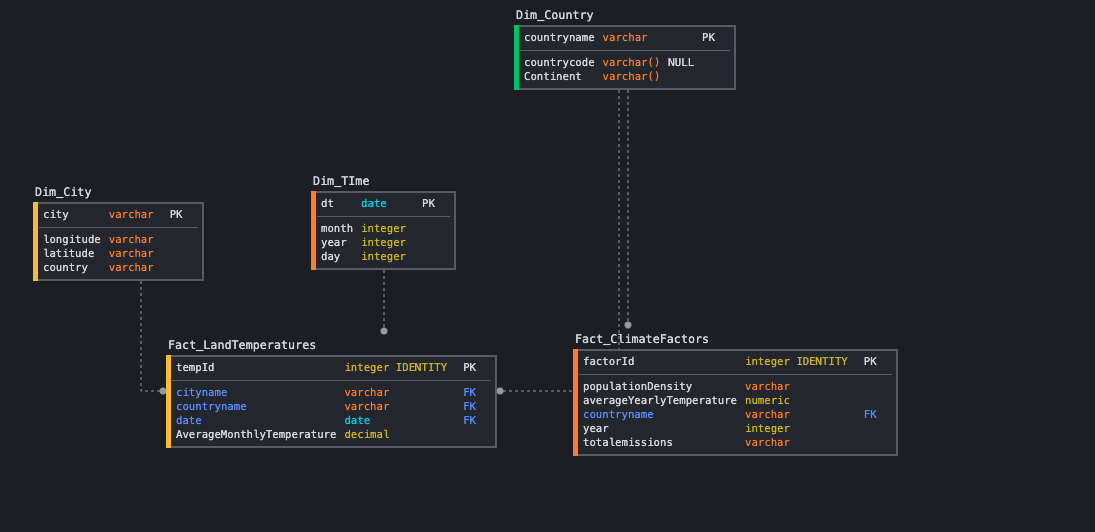

In [3]:
Image(filename='model.png') 

### 3.2 Data Pipelining

In processing the data and carrying out the ETL process, a data pipeline is created with airflow to automate the process.

In creating the pipeline the following task are created:
- Create tables:-  Create tables in redshift  using Redshift editor
- Start tasks :- Dummy task that starts the pipeline
- Stage files tasks:- Task that copy parquet files saved in the cleaned_data folder to Redshift staging tables using custom operators
- Load facts tasks:- Task that loads into the facts table for redshift staging tables using custom operators
- Load Dimensions tasks - Task that loads into the dimension table form redshit staging table using custom operators
- Run quality Checks tasks - Task that does checks in the facts and dimensions table using custom operators
- End task :- Dummy task that shows that the pipeline is done


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
The data pipeline for this projet is found in the airflow files attached.

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

some unit tests for data quality check include
- check that the averageYearlyTemperature for the Climate Factors for a specific year and country matches the expected value
- Ensure that all years from 1990 to 2013 exists for a specific country in the landTemperatures and Climate Factors fact table


In [136]:
country_temp = spark.read.json("Climate_Data/GlobalLandTempByCountry/part-00000-51b009eb-89a7-4561-a0bc-c7588b062635-c000.json")
adland_temp = country_temp.filter((col("Country") == "Afghanistan") & (col("Year")== 2002) )
value = adland_temp.agg(avg(col("AverageTemperature")))
value.show()
    
    

+-----------------------+
|avg(AverageTemperature)|
+-----------------------+
|     15.537666666666668|
+-----------------------+



from the above for afghanistan at the year 2002 the expected AverageYearlyTemperature is 15.537666666666668. We use this as our expected value for unit test.

Also our expected count for unique year for a specific country needs to be equal to 2013 - 1990 = 23

#### 4.3 Data dictionary 


The data dictionary for the project is include as part of the files for this notebook

#### Step 5: Complete Project Write Up


This project was done with s3, Amazon Redshift, Apache Spark and Airflow. The reasons for using these tools includes:
- Familarity with the tools
- Amazon Redshift is accepted in the industry as a very good tool for data warehousing especailly because of the columnar stores.
- Likewise Apache Airflow amongst others is an easy tool for building data pipelines,that easily integrable using custom hooks to many services both on cloud and locally. It is also easily extendable using custom operators.
- Amazon s3 is a cheap and effective tool for data storage.
- Apache Spark provides the ability to analyze data faster including big data and carry out ETL using clusterization.
    

Some queries that can help the ananlytics team get the result of soem of the problems listed on the scope of this project is included below


#### Relationship between populationdensity, totalghgemissions and averageyearlytemperature : 

"SELECT totalemissions , populationdensity , averageyearlytemperature from climatefactors"

Sample result below

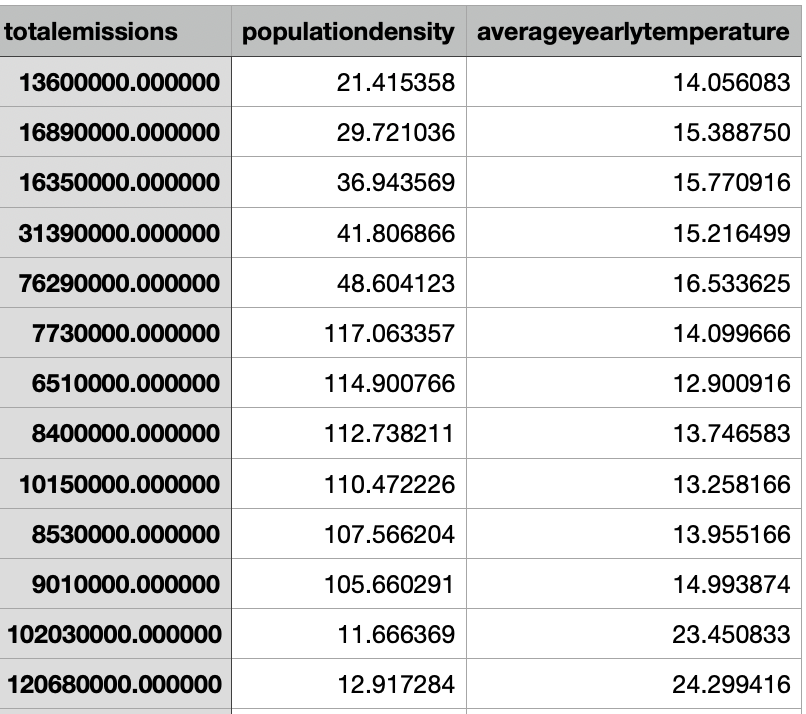

In [8]:
Image(filename='relationship.png',width = 400, height = 200) 

#### Timeseries between populationdensity, totalghgemissions and averageyearlytemperature for a specific country: 

'''
SELECT totalemissions , populationdensity , averageyearlytemperature, year, countryname 
from climatefactors 
where countryname='Afghanistan' 
order by year
'''

Sample result below

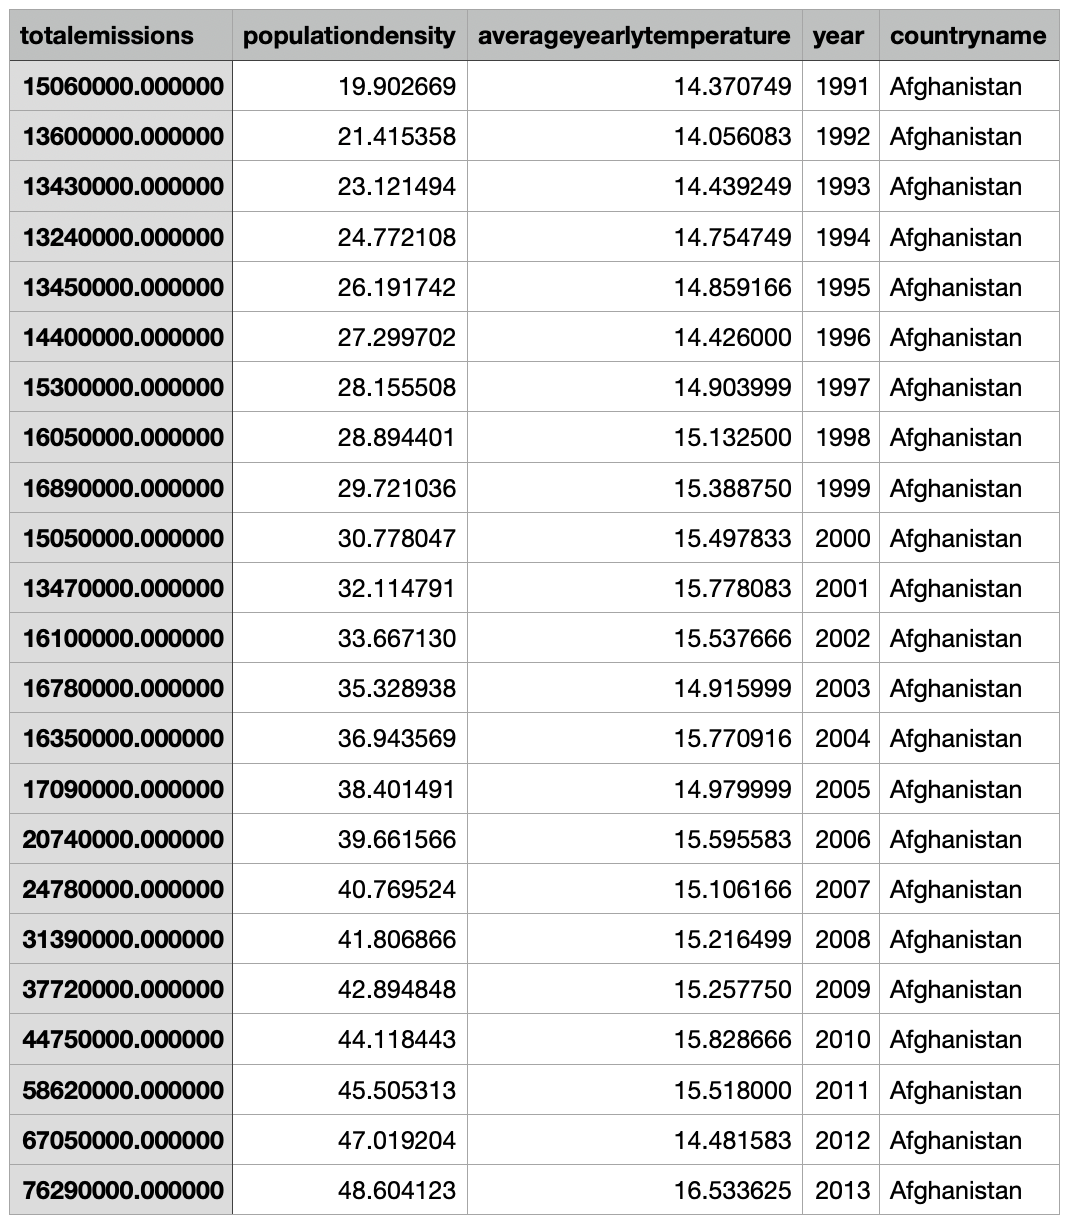

In [10]:
Image(filename='timeseries.png',width = 500, height = 200) 

#### Relationship between month, and  average land temperatures: 

"select cityname, extract(month from date) as month, extract(year from date) as year,averagemonthlytemperature from  landtemperatures order by averagemonthlytemperature desc"

Sample result below

In [ ]:
Image(filename='monthrelationship.png',width = 400, height = 200) 

The results above shows that july and august happens to be the hottest period and especially so in UAE, showing that the time of the year in a country has an effect on average land temperatures too

This data for the landtemperatures needs to be updated on a monthly basis because the data is collected monthly . Likewise the data for the climaticfactors can be updated on a yearly bases for countries. 

#### However if the data was increased by 100x, the following optimization can be made:

- Data tables should be partitioned
- For the climate factors fact table, data can be partitioned by year. For the land temperatures fact table data can be  partitioned by date.
- To manage large storage ensure that compression is set in redshift warehouse and storage auto-scaling is configured.


Also if the data from this warehouse was to populate a dashboard that needs to be updated on a daily basis by 7am everyday, then the data pipeline in Apache Airflow can be scheduled to run at 7am daily and also a task that populates the dashboard using a custom hook should be included in the data pipeline as a step after running quality checks. To do this:
- change the @schedule_interval option of the dag to "0 7  * * * ". This would run the dag once a day at 7am
- Add a task of updating dashboard. This would have an operator that hooks to any of the analytics software. Could be google analytics, salesforce, spreadsheets e.t.c
- Add task dependency for it to run after quality checks have been made to ensure that the data been added or updated is ok. run_quality_check >> update_dashboard

However running an ETl at 7am might be too late especially if the scheduled task has not finished running before clietnts starts trying to access it. It is more suitable to run this at the early hours of the morning like 2 AM or midnight.

This will incure extra cost especially if the Airflow is cloud managed as you pay on an hourly basis for when your airflow environment runs. This is really not neccessarily as the data is only updated monthly and so updating the dashboard daily with the same data would still return the same result

#### If the data was accessed by 100+ people and the business cannot afford the database to be down:-

Then database replication would be made to ensure that even if one replica fails thenother can still serve the clients.  The data engineer can set up cross region replication. Also the memory of the redshift cluster should be able to autoscale. The users will be given a read access using Select permissions.